# Code Credit
Modified from https://github.com/vntkumar8/musical-instrument-classification under Open Source license.

## Summary of changes
Increase classification ability by supplementing IRMAS with generated noisy examples.

In [2]:
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import pandas as pd
import numpy as np
from statistics import stdev
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import itertools

In [3]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
import tqdm

# Preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score

# Creating features from audio files

In [5]:
header = 'filename rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [6]:
file = open('../dataset/data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [7]:
Instruments = 'cel cla flu gac gel org pia sax tru vio voi'.split()
for i in Instruments:
    for filename in tqdm.tqdm(os.listdir(os.path.join('../dataset/IRMAS-TrainingData', f'{i}'))):
        songname = os.path.join('../dataset/IRMAS-TrainingData', i, filename)
        y, sr = librosa.load(songname, sr =44100)
        
        # Sometimes add a random amount of noise to signal
        if np.random.randint(0, 10) >= 7:
            noise=np.random.normal(0, np.random.random_sample() / 10, y.shape[0])
            y += noise
        
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {i}'
        file = open('../dataset/data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

100%|██████████| 778/778 [01:01<00:00, 12.55it/s]


In [24]:
df = pd.read_csv('../dataset/data.csv')
df.head()

,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,008__[cel][nod][cla]0058__1.wav,0.005622,1273.967038,1974.181216,2121.477777,0.033642,-548.299316,189.765564,-21.121988,15.259335,...,-0.564254,1.159621,-0.287216,-1.051063,2.558362,7.008935,9.611934,6.723992,2.892501,cel
1,008__[cel][nod][cla]0058__2.wav,0.009950,1369.496771,1985.402338,2307.544605,0.035053,-492.253021,180.435959,-30.720634,16.488262,...,-3.774964,-4.976338,-5.985732,-12.421291,-7.708522,-5.190786,0.197547,10.872709,21.063335,cel
2,008__[cel][nod][cla]0058__3.wav,0.015884,1515.558971,2010.045759,2452.374103,0.041344,-445.286987,170.886612,-36.930515,13.339684,...,-1.129981,0.303812,2.144062,3.028069,4.692125,1.315577,-4.312213,-6.950765,-1.198687,cel
3,012__[cel][nod][cla]0043__1.wav,0.017558,1764.444040,2402.842740,3208.613545,0.042100,-370.563354,182.482651,-35.701279,31.877964,...,-3.459521,-4.016848,-2.542539,2.515918,3.337309,-1.405248,-2.197753,0.097689,-1.399735,cel
4,012__[cel][nod][cla]0043__2.wav,0.067676,10725.931851,6496.838211,18631.541649,0.467717,-92.736626,4.565805,3.992283,2.363016,...,-2.102218,-2.351212,-1.443668,-0.069437,0.735313,0.763398,0.884749,1.238959,0.887407,cel


In [25]:
df.shape
features = df[df.columns[2:26]]

# PCA Analysis

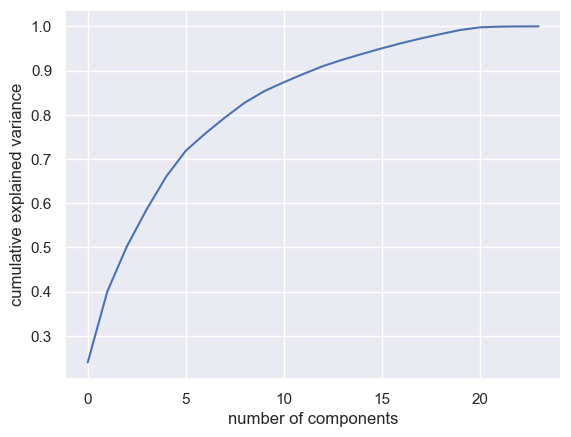

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
X = scale(features)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [27]:
# Dropping unneccesary columns
df = df.drop(['filename'],axis=1)

In [28]:
df1 = shuffle(df)

In [29]:
df1

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
695,0.201333,3793.597534,4940.015221,9100.397223,0.065422,-88.401268,111.691017,14.911218,28.337444,-3.658287,...,-0.125636,-2.280464,-7.613894,6.022198,4.186427,-8.444089,-3.301798,-2.045076,-1.199012,cla
4126,0.014896,800.247290,1341.740462,1136.105099,0.023217,-525.608459,229.781067,31.684204,-15.790149,-0.957161,...,-5.877869,-4.918493,-3.494540,-2.068573,-0.893294,-1.325376,-2.379038,2.065644,8.320130,pia
1531,0.026215,1001.375331,1928.648104,1515.139358,0.019986,-439.867432,199.683533,14.500894,7.990244,15.599740,...,-9.223978,-9.265177,-1.363257,2.129256,1.751750,-6.202394,-9.614069,-9.819162,-14.508178,gac
551,0.040701,1128.233657,1375.107246,2043.492663,0.033980,-371.045837,223.180618,-33.403019,2.155948,23.459492,...,-6.991527,-12.730908,-19.143200,-16.605461,-6.822931,0.646954,1.425687,-0.538995,-4.685390,cla
3633,0.012439,668.487677,1279.774202,949.871991,0.018681,-536.803833,238.015839,40.712921,-2.805006,17.160910,...,-6.265369,-11.759962,-7.978977,-1.436896,-0.215675,0.806776,2.948763,2.955977,1.443586,pia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5762,0.090737,2320.889107,3143.194640,5395.605469,0.043391,-214.087662,158.159683,-14.206798,48.282139,-16.390524,...,-5.101663,1.295175,4.155134,7.010982,-3.013330,-2.578710,-3.830314,-0.710958,-0.579126,vio
2332,0.200549,2109.447179,2718.370256,4694.903399,0.033060,-131.773529,159.789062,-38.281006,52.449768,0.598851,...,4.339338,4.106470,6.437533,6.202764,3.399796,8.988420,6.431317,5.661623,-4.940754,gel
1307,0.054757,2432.261926,2660.392711,4613.509554,0.061802,-271.591278,141.451309,-62.799038,35.478786,-10.899677,...,14.343613,8.353825,0.214435,-1.974331,-9.745189,-10.797748,-3.993867,4.294547,-2.948138,flu
6350,0.162842,8990.393202,6922.279587,17824.420661,0.262337,-26.144693,41.332249,20.086555,12.312155,11.318896,...,0.470337,0.872704,-0.589983,-0.926660,-1.529212,-2.766626,-4.007716,-5.331608,-5.184260,voi


In [30]:
instru_list = df1.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(instru_list)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

from joblib import dump
dump(scaler, 'std_scaler_noisy.bin', compress=True)

['std_scaler_noisy.bin']

In [31]:
y

array([ 1,  6,  3, ...,  2, 10,  2])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Supervised Algorithms

### SVM

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distributions
param_dist = {'C': uniform(0.1, 20),          # Uniform distribution between 0.1 and 20
              'kernel': ['rbf'],
              'degree': randint(2, 5),          # Discrete uniform distribution between 2 and 4
              'gamma': [0.1, 1, 10, 100]}

# Create the SVC model
svc = SVC()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", random_search.best_params_)

Best Parameters:  {'C': 14.364895744459899, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


In [34]:
svc = SVC(kernel='rbf', C = 14.364895744459899, degree=2, gamma=0.1, probability=True)

In [35]:
print(X_train[0], y_train[0])

[-1.21526073 -0.8739577  -1.10074225 -0.92044778 -0.66443427 -1.63615418
  1.15062189 -0.12566491 -1.29333928  1.35986943 -1.76556044 -1.38747918
 -0.86854448 -1.22237633 -2.27675629 -1.58722749 -1.62500935 -1.85785409
 -0.03617321  0.52996602  0.44231189  0.34604852  1.25140026  0.08975569
 -0.16484641] 7


In [36]:
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.5384041759880686

# Save the model

In [37]:
import pickle

#
# Create your model here (same as above)
#

# Save to file in the current working directory
pkl_filename = "their_tuned_model_noisy.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
#Ypredict = pickle_model.predict(Xtest)

Test score: 53.84 %


In [38]:
predicted_labels = svc.predict(X_test)

In [39]:
print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
print(confusion_matrix(y_test, predicted_labels))

Recall:  [0.43529412 0.5        0.4950495  0.66101695 0.62424242 0.55555556
 0.5625     0.44444444 0.51724138 0.44827586 0.58108108]
Precision:  [0.52112676 0.4173913  0.45045045 0.56115108 0.66025641 0.55555556
 0.50625    0.51485149 0.58823529 0.47706422 0.6056338 ]
F1-Score:  [0.47435897 0.4549763  0.47169811 0.60700389 0.64174455 0.55555556
 0.53289474 0.47706422 0.55045872 0.46222222 0.59310345]
Accuracy: 0.54  , 722
Number of samples: 1341
[[ 37   4   4   8   3   3   7   5   3  10   1]
 [  3  48   8   3   2   3  10   4   4   7   4]
 [  5   6  50   2   1  12   6   5   8   4   2]
 [  2   3   5  78   4   3   5   3   0   6   9]
 [  5   1   3   8 103   9   9   5   6   5  11]
 [  1   4  11   7   8  75   7   5   3   4  10]
 [  3   9   8   9   5   7  81   7   7   5   3]
 [  5  14   5   5   6   0  13  52   6   7   4]
 [  0  17   6   4   4   6   4   6  60   6   3]
 [  8   5   7   7   5   5  12   3   3  52   9]
 [  2   4   4   8  15  12   6   6   2   3  86]]


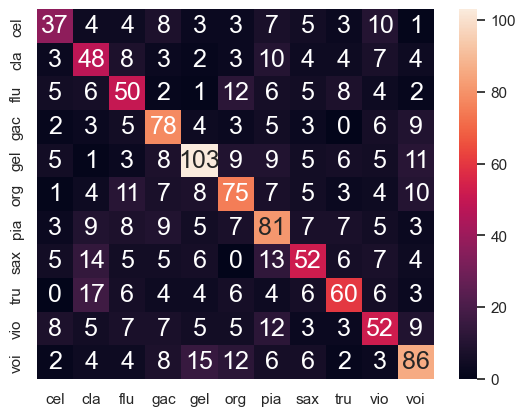

In [40]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt  
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted_labels),index=Instruments, columns=Instruments)
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.0)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 18},fmt='g')# font size

plt.show()